In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor, Pool, cv
import optuna
import warnings
from sklearn.model_selection import KFold
import math

from scipy.spatial.distance import cdist
warnings.filterwarnings("ignore")

In [49]:
class CFG:
    TARGET = ['nivel_y']
    N_FOLDS = 5
    RANDOM_STATE = 3
    TEST_SIZE = 0.2
    VAL_SIZE = 0.2  

    # PATH_TRAIN = './data/ThreeRanges/400600/400-600_CALIB.csv'
    # PATH_TEST = './data/ThreeRanges/400600/400-600_TEST.csv'

    PATH_TRAIN = './data/ThreeRanges/200400/200-400_CALIB.csv'
    PATH_TEST = './data/ThreeRanges/200400/200-400_TEST.csv'

    # PATH_TRAIN = './data/ThreeRanges/0200/0-200_CALIB.csv'
    # PATH_TEST = './data/ThreeRanges/0200/0-200_TEST.csv'
    
    TARGET_SCALER = None  # 'standard', 'minmax', 'log'

In [50]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from typing import Tuple, List

class DataLoader:
    def __init__(self, df: pd.DataFrame, target_cols: List[str] = ['nivel_y']):
        self.df = df.copy()
        self.target_cols = target_cols
        self.X = None
        self.y = None
        self.feature_names_ = []
        self.feature_scaler = StandardScaler()
        self.target_scaler = None

    @staticmethod
    def reduce_mem_usage(dataframe: pd.DataFrame) -> pd.DataFrame:
        """Оптимизация памяти с пропуском временных и категориальных колонок."""
        start_mem = dataframe.memory_usage().sum() / 1024**2
        print(f"Изначальное использование памяти: {start_mem:.2f} MB")

        for col in dataframe.columns:
            col_type = dataframe[col].dtype
            if str(col_type).startswith('datetime') or str(col_type) == 'category':
                continue

            if col_type != object:
                c_min = dataframe[col].min()
                c_max = dataframe[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        dataframe[col] = dataframe[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        dataframe[col] = dataframe[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        dataframe[col] = dataframe[col].astype(np.int32)
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        dataframe[col] = dataframe[col].astype(np.float32)
                    else:
                        dataframe[col] = dataframe[col].astype(np.float64)
            else:
                dataframe[col] = dataframe[col].astype('category')

        end_mem = dataframe.memory_usage().sum() / 1024**2
        print(f"Итоговое использование памяти: {end_mem:.2f} MB "
              f"(экономия {(start_mem - end_mem) / start_mem * 100:.1f}%)")
        return dataframe

    def _detect_time_series_cols(self) -> pd.DataFrame:
        """Автоматически определяет временные ряды как все числовые столбцы до мета-признаков."""
        meta_candidates = self.df.columns[-30:]  # расширенный буфер
        meta_numeric = self.df[meta_candidates].select_dtypes(include=[np.number]).columns
        known_meta = { 'time', 'center_vim_bubble_X', 'center_vim_bubble_Y',
            'method_vim', 'watch_indicator', 'nivel_x', 'nivel_y', 'nivel_t',
            'temperature', 'laser_x', 'laser_y', 'method_laser', 'state_leds',
            'Comment', 'source_file', 'brig_mean', 'centroid_x_brig',
            'centroid_y_brig', 'centroid_x', 'centroid_y', 'form_factor',
            'aspect_ratio', 'point_density', 'circularity',
            'bounding_box_diagonal', 'orientation_angle', 'n_points', 'brig_skew'
        }
        meta_cols = [c for c in self.df.columns if c in known_meta or c in meta_numeric]
        ts_cols = [c for c in self.df.columns if c not in meta_cols and pd.api.types.is_numeric_dtype(self.df[c])]
        return self.df[ts_cols]

    def _engineer_time_series_features(self, ts_df: pd.DataFrame) -> pd.DataFrame:
        """Генерация признаков из временных рядов."""
        features = pd.DataFrame(index=ts_df.index)
        ts_df = ts_df.fillna(0)

        features['ts_mean'] = ts_df.mean(axis=1)
        features['ts_std'] = ts_df.std(axis=1)
        features['ts_min'] = ts_df.min(axis=1)
        features['ts_max'] = ts_df.max(axis=1)
        features['ts_range'] = features['ts_max'] - features['ts_min']
        features['ts_skew'] = ts_df.skew(axis=1)
        features['ts_kurt'] = ts_df.kurtosis(axis=1)
        features['ts_last'] = ts_df.iloc[:, -1]
        features['ts_first'] = ts_df.iloc[:, 0]
        features['ts_diff'] = features['ts_last'] - features['ts_first']
        features['ts_nonzero_ratio'] = (ts_df != 0).mean(axis=1)

        window = min(10, ts_df.shape[1])
        features['ts_rolling_mean'] = ts_df.iloc[:, -window:].mean(axis=1)
        features['ts_rolling_std'] = ts_df.iloc[:, -window:].std(axis=1)

        return features

    def _extract_meta_features(self) -> pd.DataFrame:
        """Извлекает известные мета-признаки, пропуская нечисловые и таргет."""
        all_meta_cols = [
            'center_vim_bubble_X', 'center_vim_bubble_Y',
            'nivel_x', 'nivel_t',
            'temperature',
            'laser_x', 'laser_y',
            'brig_mean', 'centroid_x_brig', 'centroid_y_brig',
            'centroid_x', 'centroid_y',
            'form_factor', 'aspect_ratio', 'point_density',
            'circularity', 'bounding_box_diagonal',
            'orientation_angle', 'n_points', 'brig_skew'
        ]
        # Фильтруем существующие и числовые
        meta_cols = [c for c in all_meta_cols if c in self.df.columns and pd.api.types.is_numeric_dtype(self.df[c])]
        return self.df[meta_cols].fillna(0)

    def load(self, target_scaler_type: str = 'standard') -> Tuple[pd.DataFrame, pd.Series]:
        print(" → Загрузка и обработка данных...")

        # 1. Оптимизация памяти
        self.df = self.reduce_mem_usage(self.df)

        # 2. Извлечение y
        if len(self.target_cols) == 1:
            self.y = self.df[self.target_cols[0]].astype(np.float32)
        else:
            self.y = self.df[self.target_cols].astype(np.float32)

        # 3. Извлечение признаков
        ts_df = self._detect_time_series_cols()
        ts_features = self._engineer_time_series_features(ts_df)
        meta_features = self._extract_meta_features()

        self.X = pd.concat([ts_features, meta_features], axis=1)
        self.feature_names_ = self.X.columns.tolist()

        # 4. Масштабирование X
        self.X = pd.DataFrame(
            self.feature_scaler.fit_transform(self.X),
            columns=self.feature_names_,
            index=self.X.index
        )

        # 5. Масштабирование y (опционально)
        if target_scaler_type == 'standard':
            self.target_scaler = StandardScaler()
        elif target_scaler_type == 'minmax':
            self.target_scaler = MinMaxScaler()
        elif target_scaler_type == 'log':
            # лог-масштабирование применяется позже при необходимости
            self.target_scaler = None
            if (self.y <= 0).any():
                print("Отрицательные значения — log-масштабирование невозможно")
            else:
                self.y = np.log1p(self.y)
        else:
            self.target_scaler = None

        if self.target_scaler is not None:
            if len(self.target_cols) == 1:
                self.y = pd.Series(
                    self.target_scaler.fit_transform(self.y.values.reshape(-1, 1)).flatten(),
                    index=self.y.index,
                    name=self.y.name
                )
            else:
                self.y = pd.DataFrame(
                    self.target_scaler.fit_transform(self.y),
                    columns=self.y.columns,
                    index=self.y.index
                )

        print(f" → Целевая переменная: min={self.y.min():.3f}, max={self.y.max():.3f}")
        print(f" → Форма X: {self.X.shape}, форма y: {self.y.shape}")
        print(f" → Признаки ({len(self.feature_names_)}): {self.feature_names_[:10]}...")

        return self.X, self.y

In [51]:
import ast

def expand_array_column(df, col_name, prefix):
    """
    Распаковывает строковую колонку вида "[1,2,3]" в отдельные колонки.
    """
    def safe_literal_eval(x):
        if pd.isna(x) or not isinstance(x, str):
            return []
        try:
            return ast.literal_eval(x)
        except:
            return []

    arrays = df[col_name].apply(safe_literal_eval)
    max_len = arrays.apply(len).max()

    # Приведение всех массивов к одинаковой длине (заполнение NaN)
    padded = arrays.apply(lambda arr: arr + [np.nan] * (max_len - len(arr)))
    expanded = pd.DataFrame(padded.tolist(), index=df.index)

    # Имена новых колонок
    expanded.columns = [f"{prefix}_{i}" for i in range(expanded.shape[1])]

    return expanded

In [52]:
def preprocess_raw_csv(path):
    df = pd.read_csv(path, skipinitialspace=True, index_col='index', on_bad_lines='skip')

    df = df.dropna(subset=CFG.TARGET)

    if 'vim_points_brig' in df.columns:
        vim_ts = expand_array_column(df, 'vim_points_brig', 'vim')
        df = df.drop(columns=['vim_points_brig']).join(vim_ts)

    if 'laser_points_brig' in df.columns:
        laser_ts = expand_array_column(df, 'laser_points_brig', 'laser')
        df = df.drop(columns=['laser_points_brig']).join(laser_ts)

    return df

In [53]:
train_df = preprocess_raw_csv(CFG.PATH_TRAIN)
test_df = preprocess_raw_csv(CFG.PATH_TEST)

nivel_conversion = 0.0047
vim_conversion = 0.0015 / nivel_conversion 

# train_df[CFG.TARGET] = train_df[CFG.TARGET] / nivel_conversion
# test_df[CFG.TARGET] = test_df[CFG.TARGET] / nivel_conversion

vim_columns = [
    'center_vim_bubble_X',
    'center_vim_bubble_Y',
    'centroid_x',
    'centroid_y',
]

# Применяем конверсию только к существующим колонкам
for col in vim_columns:
    if col in train_df.columns:
        train_df[col] = train_df[col] / vim_conversion
    if col in test_df.columns:
        test_df[col] = test_df[col] / vim_conversion

train_loader = DataLoader(df=train_df, target_cols=CFG.TARGET)
X_train, y_train = train_loader.load(target_scaler_type=CFG.TARGET_SCALER)

test_loader = DataLoader(df=test_df, target_cols=CFG.TARGET)
X_test, y_test = test_loader.load(target_scaler_type=CFG.TARGET_SCALER)

 → Загрузка и обработка данных...
Изначальное использование памяти: 10.32 MB
Итоговое использование памяти: 5.22 MB (экономия 49.4%)
 → Целевая переменная: min=-91.489, max=136.170
 → Форма X: (451, 33), форма y: (451,)
 → Признаки (33): ['ts_mean', 'ts_std', 'ts_min', 'ts_max', 'ts_range', 'ts_skew', 'ts_kurt', 'ts_last', 'ts_first', 'ts_diff']...
 → Загрузка и обработка данных...
Изначальное использование памяти: 7.69 MB
Итоговое использование памяти: 3.88 MB (экономия 49.5%)
 → Целевая переменная: min=-82.979, max=131.915
 → Форма X: (308, 33), форма y: (308,)
 → Признаки (33): ['ts_mean', 'ts_std', 'ts_min', 'ts_max', 'ts_range', 'ts_skew', 'ts_kurt', 'ts_last', 'ts_first', 'ts_diff']...


# CatBoost

In [34]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 1000, 10000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 0.01, 0.5),
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'verbose': False,
        'random_state': CFG.RANDOM_STATE,
        'task_type': 'GPU' if hasattr(CatBoostRegressor(), 'get_param') else 'CPU'
    }

    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=CFG.RANDOM_STATE
    )

    model = CatBoostRegressor(**params)
    model.fit(Pool(X_tr, y_tr), eval_set=Pool(X_val, y_val), early_stopping_rounds=50, verbose=False)

    return model.get_best_score()['validation']['RMSE']

In [35]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

[I 2025-11-21 20:07:56,011] A new study created in memory with name: no-name-cd42736d-bee1-4360-a74a-2ed75b34cb5a
[I 2025-11-21 20:08:06,692] Trial 0 finished with value: 52.82401501684627 and parameters: {'iterations': 1356, 'learning_rate': 0.00010035839437603675, 'depth': 4, 'l2_leaf_reg': 6.586851870530893, 'random_strength': 0.23821123395808322}. Best is trial 0 with value: 52.82401501684627.
[I 2025-11-21 20:09:55,244] Trial 1 finished with value: 16.0012755839183 and parameters: {'iterations': 6852, 'learning_rate': 0.0002953426325836854, 'depth': 9, 'l2_leaf_reg': 8.778177616651567, 'random_strength': 0.16400448998814868}. Best is trial 1 with value: 16.0012755839183.
[I 2025-11-21 20:10:16,269] Trial 2 finished with value: 8.551581199732889 and parameters: {'iterations': 2512, 'learning_rate': 0.005211479481508021, 'depth': 6, 'l2_leaf_reg': 5.071514539513478, 'random_strength': 0.10723889841225068}. Best is trial 2 with value: 8.551581199732889.
[I 2025-11-21 20:10:18,207] Tr

In [36]:
best_params = study.best_params
best_params.update({
    'iterations' : 10000,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'verbose': 100,
    'early_stopping_rounds': 1000,
    'random_state': CFG.RANDOM_STATE,
    'task_type': 'GPU' if 'GPU' in best_params.get('task_type', 'CPU') else 'CPU'
})

final_model = CatBoostRegressor(**best_params)
final_model.fit(
    Pool(X_train, y_train),
    eval_set=Pool(X_test, y_test),
    verbose=100,
    early_stopping_rounds=1000
)


0:	learn: 57.1854000	test: 59.7050248	best: 59.7050248 (0)	total: 24.1ms	remaining: 4m 1s
100:	learn: 1.2387033	test: 14.4904350	best: 14.4883164 (94)	total: 2.4s	remaining: 3m 54s
200:	learn: 0.4118852	test: 14.4534914	best: 14.4518275 (184)	total: 4.68s	remaining: 3m 48s
300:	learn: 0.1398105	test: 14.4454403	best: 14.4380228 (246)	total: 7.03s	remaining: 3m 46s
400:	learn: 0.0552971	test: 14.4468841	best: 14.4380228 (246)	total: 9.42s	remaining: 3m 45s
500:	learn: 0.0221288	test: 14.4455052	best: 14.4380228 (246)	total: 11.7s	remaining: 3m 41s
600:	learn: 0.0084698	test: 14.4445920	best: 14.4380228 (246)	total: 14s	remaining: 3m 38s
700:	learn: 0.0033155	test: 14.4444395	best: 14.4380228 (246)	total: 16.3s	remaining: 3m 35s
800:	learn: 0.0012747	test: 14.4443620	best: 14.4380228 (246)	total: 18.5s	remaining: 3m 33s
900:	learn: 0.0005167	test: 14.4443377	best: 14.4380228 (246)	total: 20.8s	remaining: 3m 30s
1000:	learn: 0.0002125	test: 14.4443239	best: 14.4380228 (246)	total: 23.2s	r

In [37]:
print(f"Статистика по nivel_y: {y_test.std():.4f}")

Статистика по nivel_y: 64.3850


In [42]:
from sklearn.metrics import mean_absolute_error

y_pred = final_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mean = np.mean(y_test - y_pred)
std_err = np.std(y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n=== FINAL RESULTS ===")
print(f"Test MEAN:  {mean:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²:   {r2:.4f}")


=== FINAL RESULTS ===
Test MEAN:  1.6554
Test MAE:  11.5673
Test RMSE: 14.4380
Test R²:   0.9496


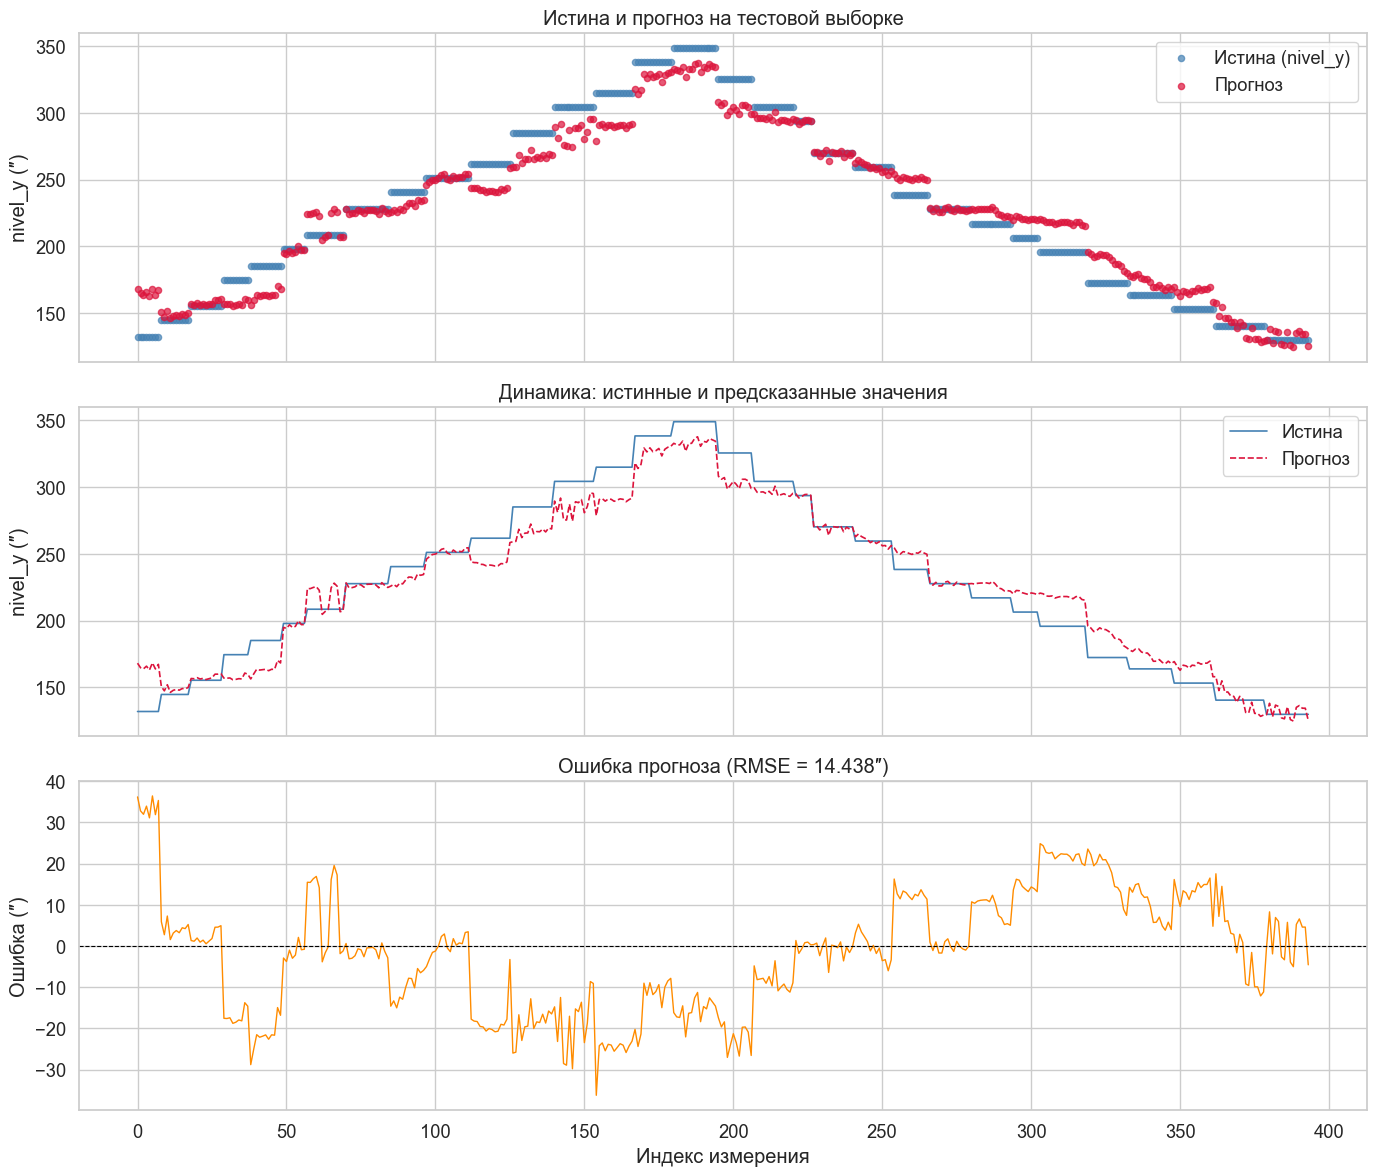

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Убедимся, что y_test и y_pred — это массивы/серии с тем же индексом
y_true = y_test.values
y_pred = final_model.predict(X_test)
errors = y_pred - y_true

# Индексы измерений (можно использовать как "время" или порядковый номер)
indices = np.arange(len(y_true))

# Настройка стиля
sns.set(style="whitegrid", font_scale=1.2)
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# 1. Истина vs Прогноз (точечный график)
ax = axes[0]
ax.scatter(indices, y_true, label='Истина (nivel_y)', alpha=0.7, s=20, color='steelblue')
ax.scatter(indices, y_pred, label='Прогноз', alpha=0.7, s=20, color='crimson')
ax.set_ylabel('nivel_y (″)')
ax.set_title('Истина и прогноз на тестовой выборке')
ax.legend()
ax.grid(True)

# 2. Временной график (линии)
ax = axes[1]
ax.plot(indices, y_true, label='Истина', linewidth=1.2, color='steelblue')
ax.plot(indices, y_pred, label='Прогноз', linewidth=1.2, color='crimson', linestyle='--')
ax.set_ylabel('nivel_y (″)')
ax.set_title('Динамика: истинные и предсказанные значения')
ax.legend()
ax.grid(True)

# 3. Ошибка (разность)
ax = axes[2]
ax.plot(indices, errors, color='darkorange', linewidth=1.0)
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.set_xlabel('Индекс измерения')
ax.set_ylabel('Ошибка (″)')
ax.set_title(f'Ошибка прогноза (RMSE = {np.sqrt(np.mean(errors**2)):.3f}″)')
ax.grid(True)

# Общая настройка
plt.tight_layout()
plt.show()

In [40]:
# 1. Сохранение лучшей модели
import joblib
import os

# Создаем папку для моделей если её нет
os.makedirs('./models', exist_ok=True)

# Сохраняем лучшую модель
model_path = './models/best_catboost_model_400600.pkl'
joblib.dump(final_model, model_path)
print(f"Модель сохранена по пути: {model_path}")


Модель сохранена по пути: ./models/best_catboost_model_400600.pkl


In [54]:
# model_path = './models/best_catboost_model_0200.pkl'
model_path = './models/best_catboost_model_200400.pkl'
# 2. Загрузка модели
def load_and_predict(model_path, X_data):
    """Загрузка модели и предсказание"""
    loaded_model = joblib.load(model_path)
    predictions = loaded_model.predict(X_data)
    return predictions, loaded_model

# Проверка загрузки модели
test_predictions, loaded_model = load_and_predict(model_path, X_test)
print(f"Проверка загрузки модели - RMSE: {np.sqrt(mean_squared_error(y_test, test_predictions)):.4f}")
y_pred = loaded_model.predict(X_test)
mean = np.mean(y_test - y_pred)
mae = mean_absolute_error(y_test, test_predictions)
std_err = np.std(test_predictions)
rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
r2 = r2_score(y_test, test_predictions)

print(f"\n=== FINAL RESULTS ===")
print(f"Test MEAN:  {mean:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²:   {r2:.4f}")

Проверка загрузки модели - RMSE: 6.1860

=== FINAL RESULTS ===
Test MEAN:  -1.4387
Test MAE:  4.4364
Test RMSE: 6.1860
Test R²:   0.9903
